<h1 style="color:#ffc0cb;font-size:70px;font-family:Georgia;text-align:center;"><strong>Book Recommender System: Model</strong></h1>

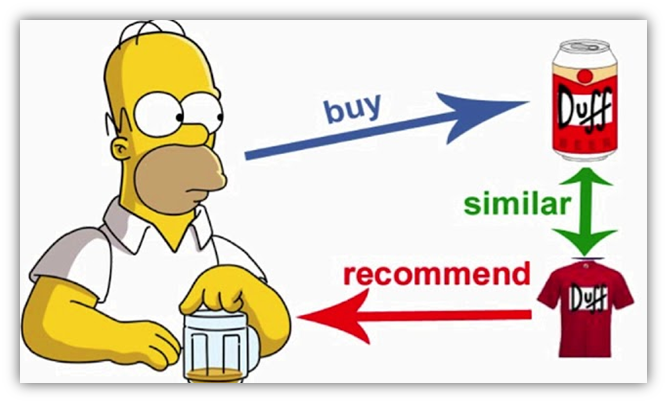

<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong> 📜 Table of Content</strong></h1>

### 4. [Types of Recommendation Engines](#4)

<br>

### 5. [Feature](#5)

<br>

### 6. [Build a Recommender System](#6)

<br>



<a id="4"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong> ⏰ 4. Types of Recommendation Engines</strong></h1>

*****

## 1. Content-Based

The Content-based filtering generates the recommendation relying on the similarity of the iteams being recommended which is recorded based on their previous acitivities or explicit feedback (rating point). In other words, the action that a user rates an item is recorded for analysing the customer and recommend a "similiar" product. This algorithm works best with the e-books since it has the content to calculate the cosin similiarity.


## 2. Collaborative Filtering

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**.

## 3. Popularity model

The considerable disadvantages of those forementioned methods are that the lackage of generating suggestions for the brand new users. In this model, it will suggest the top 10 hot books in each nation for the users.

## 4. Hybrid recommender systems

This recommender system is intergrated of the collaborative filtering and content-base filtering, so that it can minimise the disadvantages of them.

****

## Method choose:

> - I choose popularity recommender, Content-Based, Collaborative Filtering, and Hybrid recommender system.

## Why I chose:

> - First, the popularity recommender is for the new user that do not have any information yet, so I often want to recommend the higest rating for users.
> - Content-Based is for the user who want to read more on the book having the same content book.
> - Collaborative Filtering is for the user who want to explore the book that their friend like.
> - Hybrid Recommender system for minimising the problems of both of the Content-based and Collaborative Filtering.

******

<a id="5"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong> 🛠 5. Feature Engineering</strong></h1>

<a id="5.1"></a>
# 5.1 Importing Necessary Libraries and datasets:
***

In [1]:
!pip install ray
!pip install -U "ray[tune]"  # installs Ray + dependencies for Ray Tune
!pip install -U "ray[rllib]"  # installs Ray + dependencies for Ray RLlib
!pip install -U "ray[serve]"  # installs Ray + dependencies for Ray Serve

In [2]:
import sys
!{sys.executable} -m pip -q install scikit-surprise
!{sys.executable} -m pip -q install category_encoders

#Load pandas library:
import pandas as pd
# round the data in the correlation matrix
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("RdBu", 10)

#This library is for encoding
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder

#This library is for the model base collaborative filtering recommender
from surprise import SVD, NMF, SVDpp
#this is for puting the data to the model
from surprise import Dataset, Reader
#this is for hyperparameter tuning
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
import recmetrics

#This is libraries for the content based
import joblib
from joblib import parallel_backend # added line.
from ray.util.joblib import register_ray # added line.
register_ray() # added line.
#This is for convert words to vectors
import re
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('popular')
nltk.download("punkt")

# ignore DeprecationWarning Eror Messages
import warnings
warnings.filterwarnings('ignore')

#The pickle is for saving model
import pickle

#This is for Popularity
import PopularityModel
register_ray()

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/huynhchau/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/huynhchau/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/huynhchau/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/huynhchau/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/huynhchau/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/huynhchau/nltk_data...
[nltk_data]    |   Package movie_

<a id="5.2"></a>
# 📲 5.2 Data Retrieving:
***
Since I have the popularity recommender, content-based and collaborating fitler. In the popular recommender we do not concern about the explicit or implicit feedback. So we will load both of dataset including all rating valules and explicit rating values.

> **Sample book_user_explicit_rating Dataset**

In [3]:
## Importing the datasets
ex_rating_df = pd.read_csv("Data/Cleaned_Data/book_user_explicit_rating_cleaned.csv", encoding='utf-8')
ex_rating_df = ex_rating_df.loc[:, ~ex_rating_df.columns.str.contains('^index')]
ex_rating_df = ex_rating_df.loc[:, ~ex_rating_df.columns.str.contains('^Unnamed')]


ex_rating_df.columns = ex_rating_df.columns.str.replace(' ', '') #strip the extra-whitespaces out

print("The shape of the ORGINAL data is (row, column):", str(ex_rating_df.shape))
ex_rating_df = ex_rating_df.replace({"^\W+$":""}, regex=True)  


# drop Unnamed, it is just a number given to identify each house
ex_rating_df.head(3)

The shape of the ORGINAL data is (row, column): (151324, 12)


,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Publication_year,Publisher,Image_URL,Unique_ISBN,Age,Country,Age_Range
0,276747,0060517794,9,LITTLE ALTARS EVERYWHERE,REBECCA WELLS,2003.0,HARPERTORCH,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0060517794.0...,0060517794,25.0,USA,18-36
1,276747,0671537458,9,WAITING TO EXHALE,TERRY MCMILLAN,1995.0,POCKET,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0671537458.0...,0671537458,25.0,USA,18-36
2,276747,0679776818,8,BIRDSONG: A NOVEL OF LOVE AND WAR,SEBASTIAN FAULKS,1997.0,VINTAGE BOOKS USA,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0679776818.0...,0679776818,25.0,USA,18-36


> **Sample book_cleaned Dataset**

In [4]:
## Importing the datasets
book = pd.read_csv("Data/Cleaned_Data/book_cleaned.csv", delimiter=',', skipinitialspace = True, encoding='cp1252', on_bad_lines='skip')
book = book.loc[:, ~book.columns.str.contains('^Unnamed')]

book.columns = book.columns.str.replace(' ', '') #strip the extra-whitespaces out

print("The shape of the ORGINAL data is (row, column):", str(book.shape))

# drop Unnamed, it is just a number given to identify each house
book.head(3)

The shape of the ORGINAL data is (row, column): (266735, 6)


,ISBN,Book_Title,Book_Author,Publication_year,Publisher,Image_URL
0,0195153448,CLASSICAL MYTHOLOGY,MARK P. O. MORFORD,2002,OXFORD UNIVERSITY PRESS,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0195153448.0...
1,0002005018,CLARA CALLAN,RICHARD BRUCE WRIGHT,2001,HARPERFLAMINGO CANADA,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0002005018.0...
2,0060973129,DECISION IN NORMANDY,CARLO D'ESTE,1991,HARPERPERENNIAL,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0060973129.0...


> **Sample rating_cleaned Dataset**

In [5]:
## Importing the datasets
rating = pd.read_csv("Data/Cleaned_Data/rating_cleaned.csv", delimiter=',', skipinitialspace = True, encoding='cp1252', on_bad_lines='skip')
rating = rating.loc[:, ~rating.columns.str.contains('^Unnamed')]

rating.columns = rating.columns.str.replace(' ', '') #strip the extra-whitespaces out

print("The shape of the ORGINAL data is (row, column):", str(rating.shape))

# drop Unnamed, it is just a number given to identify each house
rating.head(3)

The shape of the ORGINAL data is (row, column): (569976, 3)


,User_ID,ISBN,Book_Rating
0,276746,0425115801,0
1,276746,0449006522,0
2,276746,0553561618,0


<a id="5.3"></a>
# 5.3 Select the columns
***

<a id="5.3.1"></a>
## 5.3.1 Select the columns for Collaborative Filtering Recommender
***

In [6]:
test = ex_rating_df.drop(columns=['Image_URL','Unique_ISBN'])
test.head()

,User_ID,ISBN,Book_Rating,Book_Title,Book_Author,Publication_year,Publisher,Age,Country,Age_Range
0,276747,0060517794,9,LITTLE ALTARS EVERYWHERE,REBECCA WELLS,2003.0,HARPERTORCH,25.0,USA,18-36
1,276747,0671537458,9,WAITING TO EXHALE,TERRY MCMILLAN,1995.0,POCKET,25.0,USA,18-36
2,276747,0679776818,8,BIRDSONG: A NOVEL OF LOVE AND WAR,SEBASTIAN FAULKS,1997.0,VINTAGE BOOKS USA,25.0,USA,18-36
3,276762,0380711524,5,SEE JANE RUN,JOY FIELDING,1992.0,AVON,25.0,GERMANY,18-36
4,276772,0553572369,7,PAY DIRT (MRS. MURPHY MYSTERIES (PAPERBACK)),RITA MAE BROWN,1996.0,BANTAM,34.0,GERMANY,18-36


In [7]:
ex_rating_df = ex_rating_df.drop(columns=['Image_URL','ISBN'])
ex_rating_df.head()

,User_ID,Book_Rating,Book_Title,Book_Author,Publication_year,Publisher,Unique_ISBN,Age,Country,Age_Range
0,276747,9,LITTLE ALTARS EVERYWHERE,REBECCA WELLS,2003.0,HARPERTORCH,0060517794,25.0,USA,18-36
1,276747,9,WAITING TO EXHALE,TERRY MCMILLAN,1995.0,POCKET,0671537458,25.0,USA,18-36
2,276747,8,BIRDSONG: A NOVEL OF LOVE AND WAR,SEBASTIAN FAULKS,1997.0,VINTAGE BOOKS USA,0679776818,25.0,USA,18-36
3,276762,5,SEE JANE RUN,JOY FIELDING,1992.0,AVON,0380711524,25.0,GERMANY,18-36
4,276772,7,PAY DIRT (MRS. MURPHY MYSTERIES (PAPERBACK)),RITA MAE BROWN,1996.0,BANTAM,0553572369,34.0,GERMANY,18-36


<a id="5.3.2"></a>
## 5.3.2 Select the columns for Collaborative Filtering Recommender
***

In [8]:
book_df_CF = ex_rating_df[['Book_Author','Unique_ISBN','Book_Title','Publication_year']]

<a id="5.4"></a>
# 5.4 Encoding
***

In [9]:
labelenc = LabelEncoder()

In [10]:
def label_encoding(df,param):
    df[param] = labelenc.fit_transform(df[param].values)
    df[param] = df[param].astype('category')

In [11]:
label_encoding(ex_rating_df, 'User_ID')
label_encoding(ex_rating_df, 'Unique_ISBN')

In [12]:
enc_data = ex_rating_df[['User_ID','Unique_ISBN','Book_Rating']]

<a id="5.5"></a>
# 5.5 Splitting data
***

In [13]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(enc_data[['User_ID', 'Unique_ISBN', 'Book_Rating']], reader)

In [14]:
trainset, testset = train_test_split(data, test_size=0.2)

<a id="5.6"></a>
# 5.6 Prepocessing data
***

In [15]:
# Drop duplicated Values
book_df_CF.drop_duplicates(inplace=True)
# Drop N.A. Values
book_df_CF.dropna(inplace=True)
book_df_CF = book_df_CF.reindex(np.random.permutation(book_df_CF.index))

<a id="5.4"></a>
# 5.4 Transfer from text to vector (Content_based):
***
Using NLP to extract the author and constructing a bag of words

## Extract corpus

In [16]:
lemmatizer = WordNetLemmatizer()
corpus =[]
for index, value in book_df_CF.iterrows():
# Needs to filter alphabetical word and lowering the case
  review = re.sub('[^a-zA-Z]',' ',book_df_CF.loc[index,'Book_Author'])
  review = review.lower()
  review = review.split()
  #Tokenize author and words
  review = [lemmatizer.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
  review = ' '.join(review)
  corpus.append(review)
    

## Inspect corpus

In [17]:
corpus

['ruth myers',
 'richard bach',
 'shannon drake',
 'coraghessan boyle',
 'diane ravitch',
 'mark kurlansky',
 'dan simmons',
 'richard bach',
 'william gibson',
 'lemony snicket',
 'henry miller',
 'lawrence block',
 'tom bianchi',
 'franz kafka',
 'jude deveraux',
 'richard wright',
 'anne mccaffrey',
 'pagan kennedy',
 'jean auel',
 'geoffrey chaucer',
 'ian mcewan',
 'julia bourland',
 'donna tartt',
 'nora robert',
 'alice mattison',
 'paul auster',
 'sheri tepper',
 'katherine deauxville',
 'linda warren',
 'isak dinesen',
 'laura child',
 'philip eastman',
 'nan ryan',
 'ken follett',
 'joshua piven',
 'dawn powell',
 'oswald wynd',
 'joe r lansdale',
 'frank herbert',
 'stephen coonts',
 'alisa valdes rodriguez',
 'sue grafton',
 'patricia cornwell',
 'jean auel',
 'rachel carson',
 'adele ashworth',
 'sidney sheldon',
 'craig spector',
 'laurell k hamilton',
 'martha grime',
 'gregory stock',
 'robert fisher',
 'steven paul martini',
 'jack canfield',
 'laura ingalls wilder',
 

## Check the length corpus

In [18]:
len(corpus)

15191

## Filter and leave only unique author in the corpus

In [19]:
corpus = np.unique(corpus)
len(corpus)

5009

## Convert words to vectors

In [20]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
#Common parameters for TFIDVectorizer:
tfid_vect = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = book_df_CF['Unique_ISBN'].tolist()
tfidf_mat =''
with joblib.parallel_backend('ray'):
    tfidf_mat = tfid_vect.fit_transform(corpus)
tfidf_feature_names = tfid_vect.get_feature_names()
tfidf_mat

<5009x63 sparse matrix of type '<class 'numpy.float64'>'
	with 1885 stored elements in Compressed Sparse Row format>

In [21]:
tfidf_mat.shape

(5009, 63)

<a id="6"></a>
<h1 style="color:#ffc0cb;font-size:40px;font-family:Georgia;text-align:center;"><strong> 🤖 6. Build a Recommender System</strong></h1>

****

> - Collaborative Filtering Recommender
> - Content based Recommender
> - Population Recommender
> - Hybrid Recommender

<a id="6.1"></a>
# 6.1 Collaborative Filtering Recommender
***
Collaborative Filtering Recommender includes memory base Collaborative Filtering Recommender

# Paraphase this:
Model based approach involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.

Memory based algorithms apply statistical techniques to the entire dataset to calculate the predictions. They can be divided into two main sections: user-item filtering and item-item filtering. The closest users or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are solely based on arithmetic operations.



<a id="6.1.1"></a>
## 6.1.1 Memory Based Collaborative Filtering Recommender
***
I have to split the data set again since this data does not require to use library. 

In [22]:
from sklearn.model_selection import train_test_split
# Data
df_memory_based_CF = ex_rating_df[['User_ID', 'Unique_ISBN', 'Book_Rating']]
train_data, test_data = train_test_split(df_memory_based_CF, test_size=0.2, shuffle=False, random_state=0)

Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [23]:
ex_rating_df['User_ID'] = ex_rating_df['User_ID'].astype('int') 
ex_rating_df['Unique_ISBN'] = ex_rating_df['Unique_ISBN'].astype('int') 

In [24]:
n_users = ex_rating_df['User_ID'].max()
n_movies = ex_rating_df['Unique_ISBN'].max()

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(17510, 13606)
(17510, 13606)


In [25]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data_matrix, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [26]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [27]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

## Evaluation

In [28]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [29]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 6.878500325214696
Item-based CF RMSE: 6.933613787364209


In [30]:
rating['User_ID'] = rating['User_ID'].astype('string') 
book['ISBN'] = book['ISBN'].astype('string')

In [31]:
def recommend_book(predictions, userID, book, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = pd.DataFrame(predictions).reset_index(drop=True).iloc[user_row_number]
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.User_ID == (userID)]
    user_full = (user_data.merge(book, how = 'left', left_on = 'ISBN', right_on = 'ISBN').
                     sort_values(['Book_Rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = book[~book['ISBN'].isin(user_full['ISBN'])]
    recommendations = recommendations.merge(sorted_user_predictions, how = 'left',
               left_on = 'ISBN',
               right_on = sorted_user_predictions.index)
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'})
    recommendations = recommendations.sort_values('Predictions', ascending = False)
    recommendations = recommendations.iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [32]:
already_rated, memory_predictions_result = recommend_book(user_prediction, 8, book, test, 10)

User 8 has already rated 1 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [33]:
memory_predictions_result

,ISBN,Book_Title,Book_Author,Publication_year,Publisher,Image_URL
0,0195153448,CLASSICAL MYTHOLOGY,MARK P. O. MORFORD,2002,OXFORD UNIVERSITY PRESS,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0195153448.0...
1,0060973129,DECISION IN NORMANDY,CARLO D'ESTE,1991,HARPERPERENNIAL,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0060973129.0...
2,0374157065,FLU: THE STORY OF THE GREAT INFLUENZA PANDEMIC...,GINA BARI KOLATA,1999,FARRAR STRAUS GIROUX,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0374157065.0...
3,0393045218,THE MUMMIES OF URUMCHI,E. J. W. BARBER,1999,W. W. NORTON &AMP; COMPANY,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0393045218.0...
4,0399135782,THE KITCHEN GOD'S WIFE,AMY TAN,1991,PUTNAM PUB GROUP,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0399135782.0...
5,0425176428,WHAT IF?: THE WORLD'S FOREMOST MILITARY HISTOR...,ROBERT COWLEY,2000,BERKLEY PUBLISHING GROUP,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0425176428.0...
6,0671870432,PLEADING GUILTY,SCOTT TUROW,1993,AUDIOWORKS,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0671870432.0...
7,0679425608,UNDER THE BLACK FLAG: THE ROMANCE AND THE REAL...,DAVID CORDINGLY,1996,RANDOM HOUSE,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0679425608.0...
8,074322678X,WHERE YOU'LL FIND ME: AND OTHER STORIES,ANN BEATTIE,2002,SCRIBNER,HTTP://IMAGES.AMAZON.COM/IMAGES/P/074322678X.0...
9,0771074670,NIGHTS BELOW STATION STREET,DAVID ADAMS RICHARDS,1988,EMBLEM EDITIONS,HTTP://IMAGES.AMAZON.COM/IMAGES/P/0771074670.0...


<a id="6.1.2"></a>
# 6.1.2 Model Based Collaborative Filtering Recommender
***

<a id="6.1.2.a"></a>
## 6.1.2.a Comparing the SVD and NMF models
****
Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training / testing time.

## SVD:

In [34]:
# #intialise the model
# model_svd = SVD()
# #fit model and using cross validation for evaluating
# cv_results_svd = cross_validate(model_svd, data, cv=3)
# #Demonstrate the CV result
# pd.DataFrame(cv_results_svd).mean()

## NMF

In [35]:
# #intialise the model
# model_nmf = NMF()
# #fit model and using cross validation for evaluating
# cv_results_nmf = cross_validate(model_nmf, data, cv=3)
# #Demonstrate the CV result
# pd.DataFrame(cv_results_nmf).mean()

## SVDpp:

In [36]:
# #intialise the model
# model_SVDpp = SVDpp()
# #fit model and using cross validation for evaluating
# cv_results_nmf = cross_validate(model_SVDpp, data, cv=3)
# #Demonstrate the CV result
# pd.DataFrame(cv_results_nmf).mean()

### ---------> OBSERVATION
****
The SVD has a better performance so that it is choose for the representer algorithm of the model base Collaborative Filtering Recommender.

**Paraphase again**

Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.

It is used to find the best setting of parameters:

> - n_factors - the number of factors
> - n_epochs - the number of iteration of the SGD procedure
> - lr_all - the learning rate for all parameters
> - reg_all - the regularization term for all parameters

As a result, regarding the majority of parameters, the default setting is the most optimal one. The improvement obtained with Grid Search is very small.

<a id="6.1.2.b"></a>
## 6.1.2.b Hyperparamter tuning for SVD
****

In [37]:
# #initiliase the param for grid search
# params = {'n_epochs': [50, 70, 100],
#           'n_factors': [80,100,120],
#           'lr_all': [0.002, 0.005],
#           'reg_all': [0.2, 0.4, 0.6]
#          }

# gs = GridSearchCV(SVD, params, measures=['rmse', 'mae'], cv=3)
# gs.fit(data)

# print(gs.best_score['rmse'])
# print(gs.best_params['rmse'])

In [38]:
# svd = SVD(n_factors=80, n_epochs=100, lr_all=0.002, reg_all=0.2)

In [39]:
# # create an iterator object with write permission - model.pkl
# with open('CF_SVD', 'wb') as files:
#     pickle.dump(svd, files)

In [40]:
# load saved model
with open('CF_SVD' , 'rb') as f:
    svd = pickle.load(f)

<a id="6.1.2.c"></a>
## 6.1.2.c Retrain
****

In [41]:
# svd = SVD(n_factors=80, n_epochs=100, lr_all=0.002, reg_all=0.2)
svd.fit(trainset)

predictions = svd.test(testset)
predictions = pd.DataFrame(predictions)
predictions.drop("details", inplace=True, axis=1)
predictions.columns = ['User_ID', 'ISBN', 'Rating', 'svd_predictions']
predictions.head()


,User_ID,ISBN,Rating,svd_predictions
0,4989,4713,10.0,8.757517
1,1211,1698,9.0,7.813602
2,14145,6741,10.0,8.501662
3,16254,5472,9.0,7.822238
4,1850,6761,8.0,7.403329


In [42]:
predictions['memory_predictions'] = predictions['svd_predictions']
predictions['content_based_pred'] = predictions['svd_predictions']

### ------------> OBSERVATION
***
The SVD model outperformed the memory based model significantly.

## Get recommendation for valuating

In [43]:
#create model (matrix of predicted values)
memory_predictions_result = predictions.pivot_table(index='User_ID', columns='ISBN', values='memory_predictions').fillna(0)

#create model (matrix of predicted values)
svd_predictions = predictions.pivot_table(index='User_ID', columns='ISBN', values='svd_predictions').fillna(0)


In [44]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["pred"]
    recommended_items = recommended_items.sort_values('pred', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [45]:
get_users_predictions(13640, 10, svd_predictions)

[4408, 6568, 7109, 1036, 13484, 7881, 329, 12506, 5869, 8901]

In [46]:
predictions = predictions.copy().groupby('User_ID', as_index=False)['ISBN'].agg({'actual': (lambda x: list(set(x)))})

## Result for SVD and actual

In [47]:
#Get number of user in the prediction
predictions = predictions.set_index("User_ID")


In [48]:
# make recommendations for all members in the test data
svd_recs = [] = []
for user in predictions.index:
    svd_result = get_users_predictions(user, 10, svd_predictions)
    svd_recs.append(svd_result)
        
predictions['svd_predictions'] = svd_recs
predictions.head()

,actual,svd_predictions
User_ID,,
1,[12004],"[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89..."
2,[5456],"[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890..."
6,"[2211, 6102]","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ..."
7,"[785, 2211, 537]","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89..."
9,"[13452, 13380]","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8..."


## Result for Memory Based and actual

In [49]:
# make recommendations for all members in the test data
memory_recs = [] = []

for user in predictions.index:
    memory_based = get_users_predictions(user, 10, memory_predictions_result)
    memory_recs.append(memory_based)
        
predictions['memory_predictions'] = memory_recs
predictions.head()

,actual,svd_predictions,memory_predictions
User_ID,,,
1,[12004],"[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89...","[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89..."
2,[5456],"[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890...","[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890..."
6,"[2211, 6102]","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ...","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ..."
7,"[785, 2211, 537]","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89...","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89..."
9,"[13452, 13380]","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8...","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8..."


<a id="6.2"></a>
# 6.2 Content Based Recommender
***
After training the model for recommending to the users with the similiar behaviour or more specific have the related rating points. The content base is also a good model to consider since our recommender system is for books so that the content based recommender system is a good choice
****
## Sigmoid Kernel

In [50]:
from sklearn.metrics.pairwise import sigmoid_kernel
#Compute Sigmoid kernel
with joblib.parallel_backend('ray'):
    #Can be tune with gamma
    sgm = sigmoid_kernel(tfidf_mat, tfidf_mat)

In [51]:
#Inspect the sgm data
sgm[0]

array([0.76159416, 0.76159416, 0.76159416, ..., 0.76159416, 0.76159416,
       0.76159416])

## Display some title

In [52]:
indices = pd.Series(book_df_CF.index,index = book_df_CF['Book_Title'])

In [53]:
indices

Book_Title
31 DAYS OF PRAISE : ENJOYING GOD ANEW                                        251
JONATHAN LIVINGSTON SEAGULL                                                76770
WHEN DARKNESS FALLS                                                        56993
DROP CITY                                                                  57756
THE LANGUAGE POLICE:  HOW PRESSURE GROUPS RESTRICT WHAT STUDENTS LEARN     39107
                                                                           ...  
THE LAWS OF OUR FATHERS                                                    18430
MIRROR CRACKD                                                             116679
WAITING TO EXHALE                                                          22922
THE HOBBIT                                                                 12459
THE MAGICIAN'S NEPHEW                                                       6378
Length: 15191, dtype: int64

In [54]:
indices['THE SMOKE RING']

36368

## Recommender Function

In [55]:
def give_rec (title, sig = sgm):
  indices = pd.Series(book_df_CF.index, index = book_df_CF['Book_Title']).drop_duplicates()
  i = indices[title]
  arr = []
  #Get the pairwise similarity
  sgm_scores = list(enumerate(sig[i]))

  #Sort the movies
  sgm_scores = sorted(sgm_scores, key = lambda x: x[1], reverse = True)

  #Score the 10 most similar moviews 
  sgm_scores = sgm_scores [1:11]
  book_indices = [j[0] for j in sgm_scores]
  # book_indices
  return book_df_CF['Book_Title'].iloc[book_indices]

In [56]:
CB_predictions_result = give_rec('ANGEL OF DARKNESS (KEY BOOKS)')

In [57]:
print(CB_predictions_result)

76770                          JONATHAN LIVINGSTON SEAGULL
56993                                  WHEN DARKNESS FALLS
57756                                            DROP CITY
39107    THE LANGUAGE POLICE:  HOW PRESSURE GROUPS REST...
77133                      THE BASQUE HISTORY OF THE WORLD
18625                                 THE FALL OF HYPERION
1501                                       A GIFT OF WINGS
30069                                                IDORU
3917     THE AUSTERE ACADEMY (A SERIES OF UNFORTUNATE E...
7466     TROPIC OF CANCER: WITH AN INTRODUCTION BY LOUI...
Name: Book_Title, dtype: object


<a id="6.3"></a>
# 6.3 Popularity Recommender
***
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [58]:
#make recommendations for all members in the test data
popularity_recs = ex_rating_df.Unique_ISBN.value_counts().head(10).index.tolist()

pop_recs = []
for user in predictions.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
predictions['pop_predictions'] = pop_recs
predictions.head()

,actual,svd_predictions,memory_predictions,pop_predictions
User_ID,,,,
1,[12004],"[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89...","[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15..."
2,[5456],"[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890...","[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15..."
6,"[2211, 6102]","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ...","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15..."
7,"[785, 2211, 537]","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89...","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15..."
9,"[13452, 13380]","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8...","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15..."


<a id="6.4"></a>
# 6.4 Random Recommender
***
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [59]:
#make recommendations for all members in the test data

ran_recs = []
for user in predictions.index:
    random_predictions = ex_rating_df.Unique_ISBN.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
predictions['random_predictions'] = ran_recs
predictions.head()

,actual,svd_predictions,memory_predictions,pop_predictions,random_predictions
User_ID,,,,,
1,[12004],"[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89...","[12004, 8865, 8896, 8898, 8899, 8901, 8902, 89...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15...","[2221, 12282, 5341, 3634, 4258, 9678, 10021, 6..."
2,[5456],"[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890...","[5456, 8906, 8898, 8899, 8901, 8902, 8903, 890...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15...","[6209, 7102, 12479, 6018, 11714, 12708, 6113, ..."
6,"[2211, 6102]","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ...","[6102, 2211, 0, 8906, 8899, 8901, 8902, 8903, ...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15...","[10687, 2221, 9971, 8273, 5456, 11028, 2385, 4..."
7,"[785, 2211, 537]","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89...","[537, 785, 2211, 0, 8906, 8899, 8901, 8902, 89...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15...","[6574, 80, 3399, 4300, 11502, 9185, 4296, 469,..."
9,"[13452, 13380]","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8...","[13452, 13380, 8898, 8899, 8901, 8902, 8903, 8...","[2157, 4380, 12156, 2221, 1433, 1791, 5205, 15...","[10364, 6961, 11526, 1539, 3957, 3105, 5871, 1..."


<a id="6.5"></a>
# 6.5 Evaluating Model:
***
> - Recall
> - Mark Plot
> - Prediction Coverage
> - Classification Probability Plot:
>> - class_separation_plot

In [60]:
actual = predictions.actual.values.tolist()
svd_predictions = predictions.svd_predictions.values.tolist()
memory_predictions = predictions.memory_predictions.values.tolist()
pop_predictions = predictions.pop_predictions.values.tolist()
random_predictions = predictions.random_predictions.values.tolist()

In [61]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.003679864749851374,
 0.0052247123063591,
 0.006505800099236074,
 0.0071349383778422,
 0.00759825603820968,
 0.00804166459465714,
 0.008357521000116396,
 0.008621351351127252,
 0.008793704261232134,
 0.008992961792278629]

In [62]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.00015862794493664317,
 0.00026450767546963306,
 0.0003810260392140717,
 0.0004457148205909846,
 0.0004872749490344101,
 0.0005243962994869182,
 0.0005931294594836294,
 0.0006250646659952093,
 0.0006523008707202707,
 0.0006883017481863752]

In [63]:
svd_mark = []
for K in np.arange(1, 11):
    svd_mark.extend([recmetrics.mark(actual, svd_predictions, k=K)])
svd_mark


[0.6604269523860934,
 0.8315533301734155,
 0.895982660209598,
 0.9286109203032406,
 0.9477905970800613,
 0.9599958335953405,
 0.9686015720589716,
 0.9749287291871561,
 0.9794974159368982,
 0.9830093693136791]

In [64]:
mem_mark = []
for K in np.arange(1, 11):
    mem_mark.extend([recmetrics.mark(actual, memory_predictions, k=K)])
mem_mark

[0.6604269523860934,
 0.8315533301734155,
 0.895982660209598,
 0.9286109203032406,
 0.9477905970800613,
 0.9599958335953405,
 0.9686015720589716,
 0.9749287291871561,
 0.9794974159368982,
 0.9830093693136791]

## Mark Plot


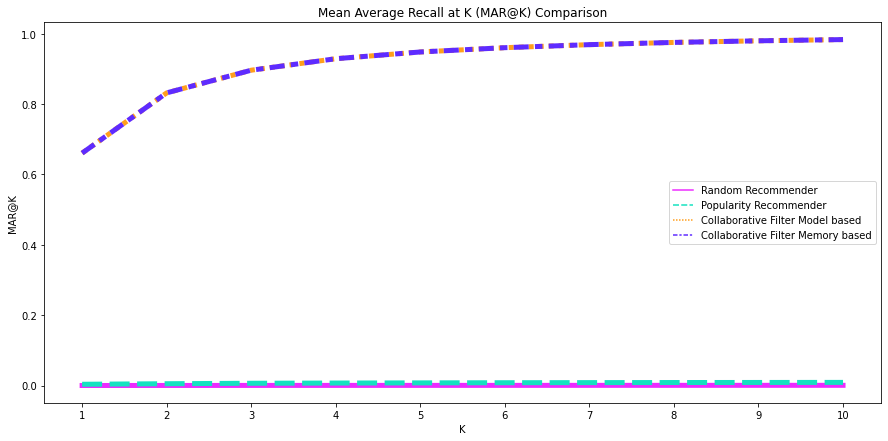

In [67]:
mark_scores = [random_mark, pop_mark, svd_mark, mem_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter Model based', 'Collaborative Filter Memory based']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)